In [1]:
import os
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import time
import matplotlib.pyplot as plt
import matplotlib.ticker

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import linear_model
from tqdm import tqdm
import pandas as pd  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
time_START = time.time()


True
NVIDIA GeForce RTX 3090


# Parameters

In [2]:
n_days = 90
BatchSize = 2048
LearningRate = 1e-3
NumEpochs = 500
WeightDecay = 0.01
StartEpoch = 0

# Data Loading

In [3]:
path = "./data"

In [4]:
df = pd.read_csv(path + '/GSPC.csv', 
                 usecols = ['Date','Open','High','Low','Close','Volume'])

data = df.to_numpy()
print(data.shape)

(12609, 6)


In [5]:
print(data[:, 3])

[108.970001 108.93 108.279999 ... 3984.600098 4077.429932 4104.879883]


# Data Preparation

## Convert to Return

In [6]:
def stock_return(x):
    rt = np.zeros((len(x)-1, 1))
    for i in range(len(rt)):
        rt[i] = np.log( (x[i+1]+1e-8) / (x[i]+1e-8) )
    
    return rt
    

In [7]:
P_Close = data[:, 3]

print(P_Close.shape)
print(P_Close)

Return_Close = stock_return(P_Close)

print(Return_Close.shape)
print(Return_Close.flatten().shape)
print(Return_Close)

del P_Close

(12609,)
[108.970001 108.93 108.279999 ... 3984.600098 4077.429932 4104.879883]
(12608, 1)
(12608,)
[[-0.00036715]
 [-0.00598502]
 [-0.00527803]
 ...
 [ 0.01506295]
 [ 0.02302992]
 [ 0.00670961]]


In [8]:
def DW_test_np(x): # Durbin Watson test
    indexing = np.arange(0, len(x), 1).reshape(-1,1)
    
    reg = linear_model.LinearRegression()
    reg.fit(indexing, x.reshape(-1,1))
    
    pred = reg.coef_ * indexing + reg.intercept_
    
    den = 0
    num = 0

    for i in range(len(pred) - 1):
        den += ((pred[i+1] - x[i+1]) - (pred[i] - x[i]))**2
        num += (pred[i+1] - x[i+1])**2

    DW = den / num
    
    return DW

In [9]:
# print(DW_test_np(Return_Close))

In [10]:
# indexing = np.arange(0, 12608, 1).reshape(-1,1)
# gfg = np.concatenate((indexing, Return_Close), axis = 1)

# print(gfg.shape)
# print(gfg)


In [11]:
# from sklearn import linear_model

# reg = linear_model.LinearRegression()

# reg.fit(indexing, Return_Close)

# print(indexing.shape)
# print(Return_Close.shape)

# print(reg.coef_)
# print(reg.intercept_)

# pred = reg.coef_ * indexing + reg.intercept_

# print(pred)
# print(pred.shape)

# den = 0
# num = 0

# for i in range(len(pred) - 1):
#     den += ((pred[i+1] - Return_Close[i+1]) - (pred[i] - Return_Close[i]))**2

# for i in range(len(pred) - 1):
#     num += (pred[i+1] - Return_Close[i+1])**2
    
# dd = den / num

# print(dd)

## Normalization

In [12]:
Return_Close_Nor = (Return_Close - Return_Close.mean(axis=0)) / Return_Close.std(axis=0) # Normalize

print(Return_Close_Nor.shape)
print(Return_Close_Nor)

(12608, 1)
[[-0.06391003]
 [-0.61208326]
 [-0.54309806]
 ...
 [ 1.441709  ]
 [ 2.21909913]
 [ 0.62661707]]


In [13]:
Return_Mean = Return_Close.mean(axis=0)
Return_Std = Return_Close.std(axis=0)

R_Mean = torch.tensor(Return_Mean).cuda()
R_Std = torch.tensor(Return_Std).cuda()
print(type(Return_Mean))
print(type(R_Mean))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


## Set Time Series Sequence

In [14]:
time_span_total = Return_Close.shape[0] - n_days
time_span_train = round(time_span_total * 0.7)
time_span_test = time_span_total - time_span_train

print(time_span_total)
print(time_span_train)
print(time_span_test)

Return_Close_Data_Train_Nor = np.zeros((time_span_train, n_days, 1))
Return_Close_Label_Train_Nor = np.zeros((time_span_train, 1))
Return_Close_Label_Train = np.zeros((time_span_train, 1))

Return_Close_Data_Test_Nor = np.zeros((time_span_test, n_days, 1))
Return_Close_Label_Test_Nor = np.zeros((time_span_test, 1))
Return_Close_Label_Test = np.zeros((time_span_test, 1))

for i in range(time_span_train):
    for j in range(n_days):
        Return_Close_Data_Train_Nor[i, j, 0] = Return_Close_Nor[i + j]
    Return_Close_Label_Train_Nor[i, 0] = Return_Close_Nor[i + n_days]
    Return_Close_Label_Train[i, 0] = Return_Close[i + n_days]

for i in range(time_span_test):
    for j in range(n_days):
        Return_Close_Data_Test_Nor[i, j, 0] = Return_Close_Nor[time_span_train + i + j]
    Return_Close_Label_Test_Nor[i, 0] = Return_Close_Nor[time_span_train + i + n_days]
    Return_Close_Label_Test[i, 0] = Return_Close[time_span_train + i + n_days]
    
print(Return_Close_Data_Train_Nor.shape)
print(Return_Close_Label_Train_Nor.shape)
print(Return_Close_Data_Test_Nor.shape)
print(Return_Close_Label_Test_Nor.shape)

print(Return_Close_Label_Train_Nor[1])
print(Return_Close_Label_Train_Nor[-1])
print(Return_Close_Label_Test_Nor[1])
print(Return_Close_Label_Test_Nor[-1])

12518
8763
3755
(8763, 90, 1)
(8763, 1)
(3755, 90, 1)
(3755, 1)
[-0.52024491]
[0.69115171]
[-0.11805309]
[0.62661707]


In [15]:
tensor_x_train = torch.Tensor(Return_Close_Data_Train_Nor).cuda()
tensor_y_train = torch.Tensor(Return_Close_Label_Train_Nor).cuda()

train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BatchSize, shuffle=False)

tensor_x_val = torch.Tensor(Return_Close_Data_Test_Nor).cuda()
tensor_y_val = torch.Tensor(Return_Close_Label_Test_Nor).cuda()

val_dataset = torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BatchSize, shuffle=False)

# Network

In [16]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
#         self.embedding = torch.nn.Sequential(            
#             nn.Conv1d(in_channels = 1, 
#                       out_channels = 128, 
#                       kernel_size = 5, 
#                       stride = 2,
#                       padding = 2, 
#                       bias = False),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
            
#             nn.Conv1d(in_channels = 128, 
#                       out_channels = 256, 
#                       kernel_size = 3, 
#                       stride = 2,
#                       padding = 1, 
#                       bias = False),
#             nn.BatchNorm1d(256),
#             nn.ReLU()
#         )
        
        self.lstm = nn.LSTM(input_size = 1, 
                            hidden_size = 512, 
                            num_layers = 4,
                            bias = True,
                            batch_first = True,
                            dropout = 0, 
                            bidirectional = False) 

        self.classification = torch.nn.Sequential(
            #nn.Linear(512, 1) 
            
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 1)
        ) 
        
    def forward(self, x):
        out1, (out2, out3) = self.lstm(x)
        out = self.classification(out1[:, -1, :])
        return out
    
model = Network().to(device)
print(model)

Network(
  (lstm): LSTM(1, 512, num_layers=4, batch_first=True)
  (classification): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


# Loss Functions

In [17]:
def Custom_MSE(y, y_t, reduction = 'mean'):
    assert len(y) == len(y_t)
    
    if reduction == 'mean':
        loss = torch.mean( torch.pow( (y - y_t) , 2) )
    elif reduction == 'sum':
        loss = torch.sum( torch.pow( (y - y_t) , 2) )
    else:
        print("ERROR. ")
        exit()
    return loss
    
    

In [18]:
def Skewness(y):
    den = torch.mean( torch.pow( (y - torch.mean(y)), 3) )
    num = torch.pow( torch.mean( torch.pow( (y - torch.mean(y)), 2) ), 3/2 )
    return den / num 

def Kurtosis(y):
    den = torch.mean( torch.pow( (y - torch.mean(y)), 4) )
    num = torch.pow( torch.mean( torch.pow( (y - torch.mean(y)), 2) ), 2 )
    return den / num 

def DW_test(x): # Durbin Watson test
    indexing = np.arange(0, len(x), 1).reshape(-1,1)
    x_np = x.cpu().detach().numpy().reshape(-1,1)
    
    reg = linear_model.LinearRegression()
    reg.fit(indexing, x_np)
    
    pred = reg.coef_ * indexing + reg.intercept_
    
    den = 0
    num = 0

    for i in range(len(pred) - 1):
        den += ((pred[i+1] - x_np[i+1]) - (pred[i] - x_np[i]))**2
        num += (pred[i+1] - x_np[i+1])**2

    DW = torch.tensor(den / num).cuda()
    
    return DW



In [19]:
def Heavy_Tail_S_Loss(y, data_mean, data_std):  
    y_un_nor = data_std * y + data_mean
    S = Skewness(y_un_nor)

    loss = 1e-3 * (1 / torch.abs(S)).cuda()
    return loss


def Heavy_Tail_K_Loss(y, data_mean, data_std):
    y_un_nor = data_std * y + data_mean
    K = Kurtosis(y_un_nor)
    
    loss = torch.pow(2, -(K) ).cuda()
    return loss


def Auto_Correlation_Loss(y):
    DW = DW_test(y)
    loss = 5 ** (torch.abs(DW - 2) / 0.5)
    
    return loss
    

In [20]:
def stock_return_np(x):
    rt = np.zeros((len(x)-1, 1))
    for i in range(len(rt)):
        rt[i] = np.log( x[i+1] / x[i] )
       
    return rt

def Skewness_np(y):
    den = np.mean( np.power( (y - np.mean(y)), 3) )
    num = np.power( np.mean( np.power( (y - np.mean(y)), 2) ), 3/2 )
    return den / num 

def Kurtosis_np(y):
    den = np.mean( np.power( (y - np.mean(y)), 4) )
    num = np.power( np.mean( np.power( (y - np.mean(y)), 2) ), 2 )
    return den / num 


In [21]:
def Custom_Loss(y, y_t, data_mean, data_std):
    
    loss = Custom_MSE(y, y_t) 
    + 12e-1 * Heavy_Tail_S_Loss(y, data_mean, data_std) 
    + 12e-1 * Heavy_Tail_K_Loss(y, data_mean, data_std)
    + 100e-1 * Auto_Correlation_Loss(y)
    
    return loss

In [22]:
def R2_Loss(output, target):
    ss_tot = torch.sum((target - torch.mean(target)) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# Training Configuration

In [23]:
criterion_train = Custom_Loss
#criterion_val = torch.nn.MSELoss(reduction='mean')
criterion_val = R2_Loss
optimizer = torch.optim.AdamW(model.parameters(), lr = LearningRate, weight_decay = WeightDecay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 5, verbose = True)


In [24]:
# def create_folder(folder_path):
#     if not os.path.exists(folder_path):
#         os.mkdir(folder_path)
        
# save_path = "./model/model_SOTA"
# create_folder(save_path)


In [25]:
def train(model, train_data, optimizer, criterion, data_mean, data_std):
    model.train()

    train_loader = torch.utils.data.DataLoader(train_data, batch_size = BatchSize, shuffle=False)
        
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    
    otpt = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.cuda()

        optimizer.zero_grad()
        output = model(data)
        
        #print(output.shape)
        
        for i in range(len(output)):
            otpt.append(output[i].detach().cpu().numpy())
            
        loss = criterion(output, target, data_mean, data_std)
        print("Train Loss: ", loss.item(), ". ")
        
        batch_bar.set_postfix(
            loss="{:.05f}".format(float(loss)),
            lr="{:.05f}".format(float(optimizer.param_groups[0]['lr'])) )  
            
        loss.backward()
        optimizer.step()
            
        batch_bar.update()
        
    return otpt


def val(model, val_data, criterion, data_mean, data_std):

    with torch.no_grad():
        
        model.eval()
        true_y_list = []
        pred_y_list = []
        
        otpt = []

        val_loader = torch.utils.data.DataLoader(val_data, batch_size = BatchSize, shuffle=False)
        
        for data, true_y in val_loader:
            data = data.cuda()
            true_y = true_y.long().cuda()                
                
            output = model(data)
            pred_y = output

            pred_y_list.extend(pred_y.tolist())
            true_y_list.extend(true_y.tolist())
            
            for i in range(len(output)):
                otpt.append(output[i].detach().cpu().numpy())

            loss = criterion(output, true_y)
            print("Validation Loss: ", loss.item(), ". ")    
            
    #val_accuracy = accuracy_score(true_y_list, pred_y_list)
    #fpr, tpr, thresholds = roc_curve(true_y_list, pred_y_list)
    #val_auc = auc(fpr, tpr)
    #print(val_accuracy)
    #print(val_auc)
    
    return otpt


## Reload the model if needed

In [26]:
# checkpoint = torch.load("./model/model_SOTA/epoch_120.txt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler = checkpoint['scheduler']
# epoch = checkpoint['epoch']

# print(epoch)

# StartEpoch = epoch + 1

# Training

In [27]:
for epoch in range(StartEpoch, NumEpochs):
    
    #start_time = time.time()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    
    model.train()
    running_loss_train = 0
    otpt_train = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()

        #data, target= data.cuda(), target.cuda()
        output = model(data)
        
        for i in range(len(output)):
            otpt_train.append(output[i].detach().cpu().numpy())
            
        loss_train = criterion_train(output, target, R_Mean, R_Std)
        running_loss_train += loss_train.item()
        
        batch_bar.set_postfix(
            loss="{:.05f}".format(float(loss_train)),
            lr="{:.05f}".format(float(optimizer.param_groups[0]['lr'])) ) 
    
        loss_train.backward()
        optimizer.step()
        
        #scheduler.step(loss_train)
        batch_bar.update()
        
    loss_train = running_loss_train / len(train_loader)
    batch_bar.close()
    
    
    # Validation
    with torch.no_grad():
        model.eval()
        running_loss_val = 0
        otpt_val = []
        
        for batch_idx, (data, target) in enumerate(val_loader):

            #data, target = data.cuda(), target.cuda()
            output = model(data)   
            
            for i in range(len(output)):
                otpt_val.append(output[i].detach().cpu().numpy())
                
            loss_val = criterion_val(output, target)
            running_loss_val += loss_val.item()

        loss_val = running_loss_val / len(val_loader)

      
    # Save the Model
#     model_path = save_path + f"/epoch_{epoch + 1}.txt"
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(), 
#         'scheduler': scheduler,
#     }, model_path)    
    
    print("--------------------------------------------------")
    print("epoch " + str(epoch + 1) + ": ")
     
    print("train loss :", loss_train, ". ")
    print("validation loss :", loss_val, ". ")

    print("--------------------------------------------------")

--------------------------------------------------
epoch 1: 
train loss : 0.8038285613059998 . 
validation loss : -0.00019657611846923828 . 
--------------------------------------------------


--------------------------------------------------
epoch 2: 
train loss : 0.8036514401435852 . 
validation loss : -0.00020176172256469727 . 
--------------------------------------------------


--------------------------------------------------
epoch 3: 
train loss : 0.8035320103168487 . 
validation loss : -7.361173629760742e-06 . 
--------------------------------------------------


--------------------------------------------------
epoch 4: 
train loss : 0.8031420767307281 . 
validation loss : -6.660819053649902e-05 . 
--------------------------------------------------


--------------------------------------------------
epoch 5: 
train loss : 0.8016829371452332 . 
validation loss : -0.001201629638671875 . 
--------------------------------------------------


--------------------------------------------------
epoch 6: 
train loss : 0.802743935585022 . 
validation loss : 0.00091552734375 . 
--------------------------------------------------


--------------------------------------------------
epoch 7: 
train loss : 0.8009752869606018 . 
validation loss : -0.004163682460784912 . 
--------------------------------------------------


--------------------------------------------------
epoch 8: 
train loss : 0.8007370054721832 . 
validation loss : 0.0001831352710723877 . 
--------------------------------------------------


--------------------------------------------------
epoch 9: 
train loss : 0.7973032712936401 . 
validation loss : -0.00868445634841919 . 
--------------------------------------------------


--------------------------------------------------
epoch 10: 
train loss : 0.7954496264457702 . 
validation loss : -0.0028884410858154297 . 
--------------------------------------------------


--------------------------------------------------
epoch 11: 
train loss : 0.7892539083957673 . 
validation loss : -0.004385858774185181 . 
--------------------------------------------------


--------------------------------------------------
epoch 12: 
train loss : 0.7780072152614593 . 
validation loss : 0.0027419626712799072 . 
--------------------------------------------------


--------------------------------------------------
epoch 13: 
train loss : 0.7699124813079834 . 
validation loss : -0.0024489164352416992 . 
--------------------------------------------------


--------------------------------------------------
epoch 14: 
train loss : 0.7625648617744446 . 
validation loss : -0.014579921960830688 . 
--------------------------------------------------


--------------------------------------------------
epoch 15: 
train loss : 0.7601973831653595 . 
validation loss : 0.006753206253051758 . 
--------------------------------------------------


--------------------------------------------------
epoch 16: 
train loss : 0.7562819421291351 . 
validation loss : -0.04260975122451782 . 
--------------------------------------------------


--------------------------------------------------
epoch 17: 
train loss : 0.7543992578983307 . 
validation loss : 0.015151381492614746 . 
--------------------------------------------------


--------------------------------------------------
epoch 18: 
train loss : 0.7632556557655334 . 
validation loss : 0.013609468936920166 . 
--------------------------------------------------


--------------------------------------------------
epoch 19: 
train loss : 0.7621009528636933 . 
validation loss : 0.0003247857093811035 . 
--------------------------------------------------


--------------------------------------------------
epoch 20: 
train loss : 0.7544919431209565 . 
validation loss : 4.500150680541992e-06 . 
--------------------------------------------------


--------------------------------------------------
epoch 21: 
train loss : 0.751718419790268 . 
validation loss : -0.01238924264907837 . 
--------------------------------------------------


--------------------------------------------------
epoch 22: 
train loss : 0.7499899744987488 . 
validation loss : -0.0037110447883605957 . 
--------------------------------------------------


--------------------------------------------------
epoch 23: 
train loss : 0.7475286722183228 . 
validation loss : -0.05481535196304321 . 
--------------------------------------------------


--------------------------------------------------
epoch 24: 
train loss : 0.7494391441345215 . 
validation loss : -0.011400669813156128 . 
--------------------------------------------------


--------------------------------------------------
epoch 25: 
train loss : 0.7453715145587921 . 
validation loss : -0.012970805168151855 . 
--------------------------------------------------


--------------------------------------------------
epoch 26: 
train loss : 0.7493287026882172 . 
validation loss : -0.0014199316501617432 . 
--------------------------------------------------


--------------------------------------------------
epoch 27: 
train loss : 0.7562991082668304 . 
validation loss : 0.004062920808792114 . 
--------------------------------------------------


--------------------------------------------------
epoch 28: 
train loss : 0.7539209365844727 . 
validation loss : -0.024180293083190918 . 
--------------------------------------------------


--------------------------------------------------
epoch 29: 
train loss : 0.7478154361248016 . 
validation loss : -0.008984655141830444 . 
--------------------------------------------------


--------------------------------------------------
epoch 30: 
train loss : 0.7430643677711487 . 
validation loss : -0.03336817026138306 . 
--------------------------------------------------


--------------------------------------------------
epoch 31: 
train loss : 0.7413654565811157 . 
validation loss : -0.018386900424957275 . 
--------------------------------------------------


--------------------------------------------------
epoch 32: 
train loss : 0.740785664319992 . 
validation loss : -0.027141034603118896 . 
--------------------------------------------------


--------------------------------------------------
epoch 33: 
train loss : 0.7351253449916839 . 
validation loss : -0.05881744623184204 . 
--------------------------------------------------


--------------------------------------------------
epoch 34: 
train loss : 0.7301907181739807 . 
validation loss : -0.017828136682510376 . 
--------------------------------------------------


--------------------------------------------------
epoch 35: 
train loss : 0.7388005793094635 . 
validation loss : -0.045474469661712646 . 
--------------------------------------------------


--------------------------------------------------
epoch 36: 
train loss : 0.7328652977943421 . 
validation loss : -0.05947691202163696 . 
--------------------------------------------------


--------------------------------------------------
epoch 37: 
train loss : 0.7247248291969299 . 
validation loss : -0.08832508325576782 . 
--------------------------------------------------


--------------------------------------------------
epoch 38: 
train loss : 0.7241030812263489 . 
validation loss : -0.05326437950134277 . 
--------------------------------------------------


--------------------------------------------------
epoch 39: 
train loss : 0.7191103398799896 . 
validation loss : -0.08001285791397095 . 
--------------------------------------------------


--------------------------------------------------
epoch 40: 
train loss : 0.7034645438194275 . 
validation loss : -0.0684884786605835 . 
--------------------------------------------------


--------------------------------------------------
epoch 41: 
train loss : 0.6957323610782623 . 
validation loss : -0.13622939586639404 . 
--------------------------------------------------


--------------------------------------------------
epoch 42: 
train loss : 0.6885933816432953 . 
validation loss : -0.2752189040184021 . 
--------------------------------------------------


--------------------------------------------------
epoch 43: 
train loss : 0.6853114187717437 . 
validation loss : -0.05883991718292236 . 
--------------------------------------------------


--------------------------------------------------
epoch 44: 
train loss : 0.7337850093841553 . 
validation loss : -0.08214813470840454 . 
--------------------------------------------------


--------------------------------------------------
epoch 45: 
train loss : 0.7979445576667785 . 
validation loss : -0.009608060121536255 . 
--------------------------------------------------


--------------------------------------------------
epoch 46: 
train loss : 0.7492258191108704 . 
validation loss : -0.002936452627182007 . 
--------------------------------------------------


--------------------------------------------------
epoch 47: 
train loss : 0.7346129715442657 . 
validation loss : -0.027362048625946045 . 
--------------------------------------------------


--------------------------------------------------
epoch 48: 
train loss : 0.7098593056201935 . 
validation loss : -0.05843925476074219 . 
--------------------------------------------------


--------------------------------------------------
epoch 49: 
train loss : 0.6985936880111694 . 
validation loss : -0.08286261558532715 . 
--------------------------------------------------


--------------------------------------------------
epoch 50: 
train loss : 0.6849317133426667 . 
validation loss : -0.09055900573730469 . 
--------------------------------------------------


--------------------------------------------------
epoch 51: 
train loss : 0.6767178356647492 . 
validation loss : -0.09037595987319946 . 
--------------------------------------------------


--------------------------------------------------
epoch 52: 
train loss : 0.6666451573371888 . 
validation loss : -0.12564617395401 . 
--------------------------------------------------


--------------------------------------------------
epoch 53: 
train loss : 0.6609438955783844 . 
validation loss : -0.1417396068572998 . 
--------------------------------------------------


--------------------------------------------------
epoch 54: 
train loss : 0.6620598495006561 . 
validation loss : -0.16785752773284912 . 
--------------------------------------------------


--------------------------------------------------
epoch 55: 
train loss : 0.6677770137786865 . 
validation loss : -0.113838791847229 . 
--------------------------------------------------


--------------------------------------------------
epoch 56: 
train loss : 0.6602915287017822 . 
validation loss : -0.11351734399795532 . 
--------------------------------------------------


--------------------------------------------------
epoch 57: 
train loss : 0.6517697393894195 . 
validation loss : -0.18838012218475342 . 
--------------------------------------------------


--------------------------------------------------
epoch 58: 
train loss : 0.6470920026302338 . 
validation loss : -0.16355150938034058 . 
--------------------------------------------------


--------------------------------------------------
epoch 59: 
train loss : 0.6444040656089782 . 
validation loss : -0.12844914197921753 . 
--------------------------------------------------


--------------------------------------------------
epoch 60: 
train loss : 0.6679431617259979 . 
validation loss : -0.1464608907699585 . 
--------------------------------------------------


--------------------------------------------------
epoch 61: 
train loss : 0.6573463380336761 . 
validation loss : -0.18767940998077393 . 
--------------------------------------------------


--------------------------------------------------
epoch 62: 
train loss : 0.6535113036632538 . 
validation loss : -0.25559669733047485 . 
--------------------------------------------------


--------------------------------------------------
epoch 63: 
train loss : 0.637544822692871 . 
validation loss : -0.2069346308708191 . 
--------------------------------------------------


--------------------------------------------------
epoch 64: 
train loss : 0.630179089307785 . 
validation loss : -0.18193602561950684 . 
--------------------------------------------------


--------------------------------------------------
epoch 65: 
train loss : 0.618834114074707 . 
validation loss : -0.13815456628799438 . 
--------------------------------------------------


--------------------------------------------------
epoch 66: 
train loss : 0.6054700970649719 . 
validation loss : -0.1940048336982727 . 
--------------------------------------------------


--------------------------------------------------
epoch 67: 
train loss : 0.5947889745235443 . 
validation loss : -0.19837141036987305 . 
--------------------------------------------------


--------------------------------------------------
epoch 68: 
train loss : 0.5829663336277008 . 
validation loss : -0.20158803462982178 . 
--------------------------------------------------


--------------------------------------------------
epoch 69: 
train loss : 0.5733487248420716 . 
validation loss : -0.22664403915405273 . 
--------------------------------------------------


--------------------------------------------------
epoch 70: 
train loss : 0.5708835422992706 . 
validation loss : -0.2154715657234192 . 
--------------------------------------------------


--------------------------------------------------
epoch 71: 
train loss : 0.5752929270267486 . 
validation loss : -0.31388986110687256 . 
--------------------------------------------------


--------------------------------------------------
epoch 72: 
train loss : 0.5742855966091156 . 
validation loss : -0.22937405109405518 . 
--------------------------------------------------


--------------------------------------------------
epoch 73: 
train loss : 0.5688084781169891 . 
validation loss : -0.17962276935577393 . 
--------------------------------------------------


--------------------------------------------------
epoch 74: 
train loss : 0.5667019426822663 . 
validation loss : -0.21491587162017822 . 
--------------------------------------------------


--------------------------------------------------
epoch 75: 
train loss : 0.5441764116287231 . 
validation loss : -0.24880290031433105 . 
--------------------------------------------------


--------------------------------------------------
epoch 76: 
train loss : 0.5362576246261597 . 
validation loss : -0.213559091091156 . 
--------------------------------------------------


--------------------------------------------------
epoch 77: 
train loss : 0.519269585609436 . 
validation loss : -0.27512460947036743 . 
--------------------------------------------------


--------------------------------------------------
epoch 78: 
train loss : 0.5076510488986969 . 
validation loss : -0.2980715036392212 . 
--------------------------------------------------


--------------------------------------------------
epoch 79: 
train loss : 0.5007882356643677 . 
validation loss : -0.2785741090774536 . 
--------------------------------------------------


--------------------------------------------------
epoch 80: 
train loss : 0.4958791196346283 . 
validation loss : -0.22047817707061768 . 
--------------------------------------------------


--------------------------------------------------
epoch 81: 
train loss : 0.4952611207962036 . 
validation loss : -0.22503000497817993 . 
--------------------------------------------------


--------------------------------------------------
epoch 82: 
train loss : 0.5150764286518097 . 
validation loss : -0.2049364447593689 . 
--------------------------------------------------


--------------------------------------------------
epoch 83: 
train loss : 0.5230685770511627 . 
validation loss : -0.38079679012298584 . 
--------------------------------------------------


--------------------------------------------------
epoch 84: 
train loss : 0.5487933218479156 . 
validation loss : -0.1900864839553833 . 
--------------------------------------------------


--------------------------------------------------
epoch 85: 
train loss : 0.5111594259738922 . 
validation loss : -0.19307541847229004 . 
--------------------------------------------------


--------------------------------------------------
epoch 86: 
train loss : 0.5030592322349549 . 
validation loss : -0.291978657245636 . 
--------------------------------------------------


--------------------------------------------------
epoch 87: 
train loss : 0.4753535509109497 . 
validation loss : -0.2191433310508728 . 
--------------------------------------------------


--------------------------------------------------
epoch 88: 
train loss : 0.4652586281299591 . 
validation loss : -0.26410973072052 . 
--------------------------------------------------


--------------------------------------------------
epoch 89: 
train loss : 0.45027117133140565 . 
validation loss : -0.26843398809432983 . 
--------------------------------------------------


--------------------------------------------------
epoch 90: 
train loss : 0.4367606997489929 . 
validation loss : -0.2870483994483948 . 
--------------------------------------------------


--------------------------------------------------
epoch 91: 
train loss : 0.4293538391590118 . 
validation loss : -0.28927719593048096 . 
--------------------------------------------------


--------------------------------------------------
epoch 92: 
train loss : 0.4150129437446594 . 
validation loss : -0.3159462809562683 . 
--------------------------------------------------


--------------------------------------------------
epoch 93: 
train loss : 0.4035901606082916 . 
validation loss : -0.3777540922164917 . 
--------------------------------------------------


--------------------------------------------------
epoch 94: 
train loss : 0.4043676733970642 . 
validation loss : -0.32216525077819824 . 
--------------------------------------------------


--------------------------------------------------
epoch 95: 
train loss : 0.399784654378891 . 
validation loss : -0.27225780487060547 . 
--------------------------------------------------


--------------------------------------------------
epoch 96: 
train loss : 0.4076905488967896 . 
validation loss : -0.21469753980636597 . 
--------------------------------------------------


--------------------------------------------------
epoch 97: 
train loss : 0.4210270822048187 . 
validation loss : -0.32416439056396484 . 
--------------------------------------------------


--------------------------------------------------
epoch 98: 
train loss : 0.4092598557472229 . 
validation loss : -0.307233989238739 . 
--------------------------------------------------


--------------------------------------------------
epoch 99: 
train loss : 0.3937415271997452 . 
validation loss : -0.28284549713134766 . 
--------------------------------------------------


--------------------------------------------------
epoch 100: 
train loss : 0.3771272569894791 . 
validation loss : -0.308971643447876 . 
--------------------------------------------------


--------------------------------------------------
epoch 101: 
train loss : 0.3638577044010162 . 
validation loss : -0.2590210437774658 . 
--------------------------------------------------


--------------------------------------------------
epoch 102: 
train loss : 0.3574791789054871 . 
validation loss : -0.27499920129776 . 
--------------------------------------------------


--------------------------------------------------
epoch 103: 
train loss : 0.3400410234928131 . 
validation loss : -0.29875582456588745 . 
--------------------------------------------------


--------------------------------------------------
epoch 104: 
train loss : 0.32933087050914767 . 
validation loss : -0.31640148162841797 . 
--------------------------------------------------


--------------------------------------------------
epoch 105: 
train loss : 0.3203916698694229 . 
validation loss : -0.31294745206832886 . 
--------------------------------------------------


--------------------------------------------------
epoch 106: 
train loss : 0.3103452831506729 . 
validation loss : -0.3130139708518982 . 
--------------------------------------------------


--------------------------------------------------
epoch 107: 
train loss : 0.3017724841833115 . 
validation loss : -0.2787400484085083 . 
--------------------------------------------------


--------------------------------------------------
epoch 108: 
train loss : 0.3028492838144302 . 
validation loss : -0.308616042137146 . 
--------------------------------------------------


--------------------------------------------------
epoch 109: 
train loss : 0.3281618982553482 . 
validation loss : -0.3457421660423279 . 
--------------------------------------------------


--------------------------------------------------
epoch 110: 
train loss : 0.3390705019235611 . 
validation loss : -0.280454158782959 . 
--------------------------------------------------


--------------------------------------------------
epoch 111: 
train loss : 0.31884211897850034 . 
validation loss : -0.24904918670654297 . 
--------------------------------------------------


--------------------------------------------------
epoch 112: 
train loss : 0.30281698107719424 . 
validation loss : -0.29959046840667725 . 
--------------------------------------------------


--------------------------------------------------
epoch 113: 
train loss : 0.29114209711551664 . 
validation loss : -0.35974055528640747 . 
--------------------------------------------------


--------------------------------------------------
epoch 114: 
train loss : 0.2987625628709793 . 
validation loss : -0.31146591901779175 . 
--------------------------------------------------


--------------------------------------------------
epoch 115: 
train loss : 0.2814977914094925 . 
validation loss : -0.30369067192077637 . 
--------------------------------------------------


--------------------------------------------------
epoch 116: 
train loss : 0.2745825558900833 . 
validation loss : -0.3257216811180115 . 
--------------------------------------------------


--------------------------------------------------
epoch 117: 
train loss : 0.25096064507961274 . 
validation loss : -0.33682864904403687 . 
--------------------------------------------------


--------------------------------------------------
epoch 118: 
train loss : 0.24394115805625916 . 
validation loss : -0.27780741453170776 . 
--------------------------------------------------


--------------------------------------------------
epoch 119: 
train loss : 0.22466510832309722 . 
validation loss : -0.3340391516685486 . 
--------------------------------------------------


--------------------------------------------------
epoch 120: 
train loss : 0.20940640568733215 . 
validation loss : -0.34625309705734253 . 
--------------------------------------------------


--------------------------------------------------
epoch 121: 
train loss : 0.20099771320819854 . 
validation loss : -0.34182363748550415 . 
--------------------------------------------------


--------------------------------------------------
epoch 122: 
train loss : 0.18794960379600525 . 
validation loss : -0.3202338218688965 . 
--------------------------------------------------


--------------------------------------------------
epoch 123: 
train loss : 0.18145440220832826 . 
validation loss : -0.3328949809074402 . 
--------------------------------------------------


--------------------------------------------------
epoch 124: 
train loss : 0.17759685218334198 . 
validation loss : -0.36660242080688477 . 
--------------------------------------------------


--------------------------------------------------
epoch 125: 
train loss : 0.17683075070381166 . 
validation loss : -0.36281728744506836 . 
--------------------------------------------------


--------------------------------------------------
epoch 126: 
train loss : 0.17991921603679656 . 
validation loss : -0.35987770557403564 . 
--------------------------------------------------


--------------------------------------------------
epoch 127: 
train loss : 0.1987590968608856 . 
validation loss : -0.33082908391952515 . 
--------------------------------------------------


--------------------------------------------------
epoch 128: 
train loss : 0.19990605115890503 . 
validation loss : -0.37055152654647827 . 
--------------------------------------------------


--------------------------------------------------
epoch 129: 
train loss : 0.20629401803016661 . 
validation loss : -0.3292246460914612 . 
--------------------------------------------------


--------------------------------------------------
epoch 130: 
train loss : 0.18530997335910798 . 
validation loss : -0.3414720296859741 . 
--------------------------------------------------


--------------------------------------------------
epoch 131: 
train loss : 0.1666925683617592 . 
validation loss : -0.329494833946228 . 
--------------------------------------------------


--------------------------------------------------
epoch 132: 
train loss : 0.155195888876915 . 
validation loss : -0.31746190786361694 . 
--------------------------------------------------


--------------------------------------------------
epoch 133: 
train loss : 0.14526325464248657 . 
validation loss : -0.3667777180671692 . 
--------------------------------------------------


--------------------------------------------------
epoch 134: 
train loss : 0.13541415482759475 . 
validation loss : -0.3182063102722168 . 
--------------------------------------------------


--------------------------------------------------
epoch 135: 
train loss : 0.12314720153808593 . 
validation loss : -0.3672580122947693 . 
--------------------------------------------------


--------------------------------------------------
epoch 136: 
train loss : 0.1184000626206398 . 
validation loss : -0.32513850927352905 . 
--------------------------------------------------


--------------------------------------------------
epoch 137: 
train loss : 0.10770568102598191 . 
validation loss : -0.39901113510131836 . 
--------------------------------------------------


--------------------------------------------------
epoch 138: 
train loss : 0.10843589752912522 . 
validation loss : -0.37847405672073364 . 
--------------------------------------------------


--------------------------------------------------
epoch 139: 
train loss : 0.10918385535478592 . 
validation loss : -0.3217478394508362 . 
--------------------------------------------------


--------------------------------------------------
epoch 140: 
train loss : 0.11511913388967514 . 
validation loss : -0.3264371156692505 . 
--------------------------------------------------


--------------------------------------------------
epoch 141: 
train loss : 0.10771898031234742 . 
validation loss : -0.42236024141311646 . 
--------------------------------------------------


--------------------------------------------------
epoch 142: 
train loss : 0.09347016364336014 . 
validation loss : -0.3274248242378235 . 
--------------------------------------------------


--------------------------------------------------
epoch 143: 
train loss : 0.08688644990324974 . 
validation loss : -0.3822159171104431 . 
--------------------------------------------------


--------------------------------------------------
epoch 144: 
train loss : 0.08081459328532219 . 
validation loss : -0.3600581884384155 . 
--------------------------------------------------


--------------------------------------------------
epoch 145: 
train loss : 0.07787052020430565 . 
validation loss : -0.34303122758865356 . 
--------------------------------------------------


--------------------------------------------------
epoch 146: 
train loss : 0.08340547382831573 . 
validation loss : -0.3961670994758606 . 
--------------------------------------------------


--------------------------------------------------
epoch 147: 
train loss : 0.08972010910511016 . 
validation loss : -0.3750402331352234 . 
--------------------------------------------------


--------------------------------------------------
epoch 148: 
train loss : 0.09705542623996735 . 
validation loss : -0.3477155566215515 . 
--------------------------------------------------


--------------------------------------------------
epoch 149: 
train loss : 0.08474117591977119 . 
validation loss : -0.3596869707107544 . 
--------------------------------------------------


--------------------------------------------------
epoch 150: 
train loss : 0.07734292224049569 . 
validation loss : -0.36270374059677124 . 
--------------------------------------------------


--------------------------------------------------
epoch 151: 
train loss : 0.06506518051028251 . 
validation loss : -0.4180215001106262 . 
--------------------------------------------------


--------------------------------------------------
epoch 152: 
train loss : 0.05748452320694923 . 
validation loss : -0.35928434133529663 . 
--------------------------------------------------


--------------------------------------------------
epoch 153: 
train loss : 0.05314643532037735 . 
validation loss : -0.4213123917579651 . 
--------------------------------------------------


--------------------------------------------------
epoch 154: 
train loss : 0.050449470058083534 . 
validation loss : -0.3532554507255554 . 
--------------------------------------------------


--------------------------------------------------
epoch 155: 
train loss : 0.047309232875704765 . 
validation loss : -0.38186997175216675 . 
--------------------------------------------------


--------------------------------------------------
epoch 156: 
train loss : 0.042242630198597905 . 
validation loss : -0.36630570888519287 . 
--------------------------------------------------


--------------------------------------------------
epoch 157: 
train loss : 0.04092944450676441 . 
validation loss : -0.3866392970085144 . 
--------------------------------------------------


--------------------------------------------------
epoch 158: 
train loss : 0.038935181125998496 . 
validation loss : -0.37471044063568115 . 
--------------------------------------------------


--------------------------------------------------
epoch 159: 
train loss : 0.03688047789037228 . 
validation loss : -0.3829110264778137 . 
--------------------------------------------------


--------------------------------------------------
epoch 160: 
train loss : 0.0347697127610445 . 
validation loss : -0.3987959027290344 . 
--------------------------------------------------


--------------------------------------------------
epoch 161: 
train loss : 0.03511308953166008 . 
validation loss : -0.362143337726593 . 
--------------------------------------------------


--------------------------------------------------
epoch 162: 
train loss : 0.03419748917222023 . 
validation loss : -0.39201611280441284 . 
--------------------------------------------------


--------------------------------------------------
epoch 163: 
train loss : 0.0354049239307642 . 
validation loss : -0.37549829483032227 . 
--------------------------------------------------


--------------------------------------------------
epoch 164: 
train loss : 0.03197724148631096 . 
validation loss : -0.37418848276138306 . 
--------------------------------------------------


--------------------------------------------------
epoch 165: 
train loss : 0.030833202600479125 . 
validation loss : -0.38448143005371094 . 
--------------------------------------------------


--------------------------------------------------
epoch 166: 
train loss : 0.03091771584004164 . 
validation loss : -0.3857507109642029 . 
--------------------------------------------------


--------------------------------------------------
epoch 167: 
train loss : 0.025931431353092192 . 
validation loss : -0.37474167346954346 . 
--------------------------------------------------


--------------------------------------------------
epoch 168: 
train loss : 0.023830358870327473 . 
validation loss : -0.404485285282135 . 
--------------------------------------------------


--------------------------------------------------
epoch 169: 
train loss : 0.024257773347198964 . 
validation loss : -0.3565160632133484 . 
--------------------------------------------------


--------------------------------------------------
epoch 170: 
train loss : 0.023500742763280867 . 
validation loss : -0.41213738918304443 . 
--------------------------------------------------


--------------------------------------------------
epoch 171: 
train loss : 0.024988370947539806 . 
validation loss : -0.3721277117729187 . 
--------------------------------------------------


--------------------------------------------------
epoch 172: 
train loss : 0.023951810598373414 . 
validation loss : -0.41142696142196655 . 
--------------------------------------------------


--------------------------------------------------
epoch 173: 
train loss : 0.024098142981529236 . 
validation loss : -0.36993443965911865 . 
--------------------------------------------------


--------------------------------------------------
epoch 174: 
train loss : 0.02446169834583998 . 
validation loss : -0.40775442123413086 . 
--------------------------------------------------


--------------------------------------------------
epoch 175: 
train loss : 0.02441281173378229 . 
validation loss : -0.3529048562049866 . 
--------------------------------------------------


--------------------------------------------------
epoch 176: 
train loss : 0.024597177281975746 . 
validation loss : -0.388993501663208 . 
--------------------------------------------------


--------------------------------------------------
epoch 177: 
train loss : 0.026385959051549435 . 
validation loss : -0.3654562830924988 . 
--------------------------------------------------


--------------------------------------------------
epoch 178: 
train loss : 0.027786671184003353 . 
validation loss : -0.3949390649795532 . 
--------------------------------------------------


--------------------------------------------------
epoch 179: 
train loss : 0.026394484005868434 . 
validation loss : -0.3674529194831848 . 
--------------------------------------------------


--------------------------------------------------
epoch 180: 
train loss : 0.02726280316710472 . 
validation loss : -0.37703317403793335 . 
--------------------------------------------------


--------------------------------------------------
epoch 181: 
train loss : 0.024292807653546335 . 
validation loss : -0.38547205924987793 . 
--------------------------------------------------


--------------------------------------------------
epoch 182: 
train loss : 0.021928486227989197 . 
validation loss : -0.3455086350440979 . 
--------------------------------------------------


--------------------------------------------------
epoch 183: 
train loss : 0.0205052999779582 . 
validation loss : -0.38038015365600586 . 
--------------------------------------------------


--------------------------------------------------
epoch 184: 
train loss : 0.01836387813091278 . 
validation loss : -0.37339597940444946 . 
--------------------------------------------------


--------------------------------------------------
epoch 185: 
train loss : 0.01815351378172636 . 
validation loss : -0.39630985260009766 . 
--------------------------------------------------


--------------------------------------------------
epoch 186: 
train loss : 0.017189271934330463 . 
validation loss : -0.36284399032592773 . 
--------------------------------------------------


--------------------------------------------------
epoch 187: 
train loss : 0.01641397625207901 . 
validation loss : -0.36118513345718384 . 
--------------------------------------------------


--------------------------------------------------
epoch 188: 
train loss : 0.015149084478616714 . 
validation loss : -0.3770734667778015 . 
--------------------------------------------------


--------------------------------------------------
epoch 189: 
train loss : 0.014591941237449646 . 
validation loss : -0.3684380054473877 . 
--------------------------------------------------


--------------------------------------------------
epoch 190: 
train loss : 0.013880822993814945 . 
validation loss : -0.3756124973297119 . 
--------------------------------------------------


--------------------------------------------------
epoch 191: 
train loss : 0.013291943073272704 . 
validation loss : -0.3686956763267517 . 
--------------------------------------------------


--------------------------------------------------
epoch 192: 
train loss : 0.013637780211865902 . 
validation loss : -0.3631123900413513 . 
--------------------------------------------------


--------------------------------------------------
epoch 193: 
train loss : 0.014254703279584646 . 
validation loss : -0.37846243381500244 . 
--------------------------------------------------


--------------------------------------------------
epoch 194: 
train loss : 0.013596358336508274 . 
validation loss : -0.3637272119522095 . 
--------------------------------------------------


--------------------------------------------------
epoch 195: 
train loss : 0.013028888963162899 . 
validation loss : -0.38477104902267456 . 
--------------------------------------------------


--------------------------------------------------
epoch 196: 
train loss : 0.013771990314126015 . 
validation loss : -0.35844630002975464 . 
--------------------------------------------------


--------------------------------------------------
epoch 197: 
train loss : 0.0139039171859622 . 
validation loss : -0.36796271800994873 . 
--------------------------------------------------


--------------------------------------------------
epoch 198: 
train loss : 0.013557404279708862 . 
validation loss : -0.3565864562988281 . 
--------------------------------------------------


--------------------------------------------------
epoch 199: 
train loss : 0.01331107523292303 . 
validation loss : -0.37405115365982056 . 
--------------------------------------------------


--------------------------------------------------
epoch 200: 
train loss : 0.01269887462258339 . 
validation loss : -0.36266863346099854 . 
--------------------------------------------------


--------------------------------------------------
epoch 201: 
train loss : 0.012128983810544013 . 
validation loss : -0.3644183278083801 . 
--------------------------------------------------


--------------------------------------------------
epoch 202: 
train loss : 0.012102955300360919 . 
validation loss : -0.3441459536552429 . 
--------------------------------------------------


--------------------------------------------------
epoch 203: 
train loss : 0.012346772663295268 . 
validation loss : -0.3605448007583618 . 
--------------------------------------------------


--------------------------------------------------
epoch 204: 
train loss : 0.012277360912412405 . 
validation loss : -0.3739205002784729 . 
--------------------------------------------------


--------------------------------------------------
epoch 205: 
train loss : 0.012661614455282688 . 
validation loss : -0.3652191758155823 . 
--------------------------------------------------


--------------------------------------------------
epoch 206: 
train loss : 0.0117660753428936 . 
validation loss : -0.371504008769989 . 
--------------------------------------------------


--------------------------------------------------
epoch 207: 
train loss : 0.013325458765029908 . 
validation loss : -0.34470146894454956 . 
--------------------------------------------------


--------------------------------------------------
epoch 208: 
train loss : 0.011781417578458787 . 
validation loss : -0.3636443018913269 . 
--------------------------------------------------


--------------------------------------------------
epoch 209: 
train loss : 0.011535307019948959 . 
validation loss : -0.3603050112724304 . 
--------------------------------------------------


--------------------------------------------------
epoch 210: 
train loss : 0.012141206581145526 . 
validation loss : -0.3598276972770691 . 
--------------------------------------------------


--------------------------------------------------
epoch 211: 
train loss : 0.011235462315380574 . 
validation loss : -0.3497154116630554 . 
--------------------------------------------------


--------------------------------------------------
epoch 212: 
train loss : 0.011475210264325141 . 
validation loss : -0.35612285137176514 . 
--------------------------------------------------


--------------------------------------------------
epoch 213: 
train loss : 0.011851370055228471 . 
validation loss : -0.3575689196586609 . 
--------------------------------------------------


--------------------------------------------------
epoch 214: 
train loss : 0.011377772875130176 . 
validation loss : -0.3577080965042114 . 
--------------------------------------------------


--------------------------------------------------
epoch 215: 
train loss : 0.01131730228662491 . 
validation loss : -0.3585245609283447 . 
--------------------------------------------------


--------------------------------------------------
epoch 216: 
train loss : 0.010706993564963341 . 
validation loss : -0.35920417308807373 . 
--------------------------------------------------


--------------------------------------------------
epoch 217: 
train loss : 0.011549798119813205 . 
validation loss : -0.3469376564025879 . 
--------------------------------------------------


--------------------------------------------------
epoch 218: 
train loss : 0.013138226326555013 . 
validation loss : -0.3645526170730591 . 
--------------------------------------------------


--------------------------------------------------
epoch 219: 
train loss : 0.01072322316467762 . 
validation loss : -0.3676717281341553 . 
--------------------------------------------------


--------------------------------------------------
epoch 220: 
train loss : 0.011036909278482198 . 
validation loss : -0.35967904329299927 . 
--------------------------------------------------


--------------------------------------------------
epoch 221: 
train loss : 0.011037611030042171 . 
validation loss : -0.3591552972793579 . 
--------------------------------------------------


--------------------------------------------------
epoch 222: 
train loss : 0.011195766367018222 . 
validation loss : -0.3672035336494446 . 
--------------------------------------------------


--------------------------------------------------
epoch 223: 
train loss : 0.011477415263652802 . 
validation loss : -0.3609086871147156 . 
--------------------------------------------------


--------------------------------------------------
epoch 224: 
train loss : 0.011314255185425282 . 
validation loss : -0.3621235489845276 . 
--------------------------------------------------


--------------------------------------------------
epoch 225: 
train loss : 0.012064657546579838 . 
validation loss : -0.36179107427597046 . 
--------------------------------------------------


--------------------------------------------------
epoch 226: 
train loss : 0.011360331811010838 . 
validation loss : -0.3456820249557495 . 
--------------------------------------------------


--------------------------------------------------
epoch 227: 
train loss : 0.011488664522767067 . 
validation loss : -0.3587900400161743 . 
--------------------------------------------------


--------------------------------------------------
epoch 228: 
train loss : 0.011512243188917637 . 
validation loss : -0.373674213886261 . 
--------------------------------------------------


--------------------------------------------------
epoch 229: 
train loss : 0.010821374133229256 . 
validation loss : -0.3460733890533447 . 
--------------------------------------------------


--------------------------------------------------
epoch 230: 
train loss : 0.011032396275550128 . 
validation loss : -0.35127151012420654 . 
--------------------------------------------------


--------------------------------------------------
epoch 231: 
train loss : 0.011083290167152881 . 
validation loss : -0.367988646030426 . 
--------------------------------------------------


--------------------------------------------------
epoch 232: 
train loss : 0.011143222544342279 . 
validation loss : -0.352586567401886 . 
--------------------------------------------------


--------------------------------------------------
epoch 233: 
train loss : 0.010504803340882062 . 
validation loss : -0.3542667031288147 . 
--------------------------------------------------


--------------------------------------------------
epoch 234: 
train loss : 0.01370871877297759 . 
validation loss : -0.37273454666137695 . 
--------------------------------------------------


--------------------------------------------------
epoch 235: 
train loss : 0.010478981770575047 . 
validation loss : -0.35938411951065063 . 
--------------------------------------------------


--------------------------------------------------
epoch 236: 
train loss : 0.010228711925446988 . 
validation loss : -0.3832973837852478 . 
--------------------------------------------------


--------------------------------------------------
epoch 237: 
train loss : 0.010438621696084737 . 
validation loss : -0.3490990400314331 . 
--------------------------------------------------


--------------------------------------------------
epoch 238: 
train loss : 0.012267362698912621 . 
validation loss : -0.3481259346008301 . 
--------------------------------------------------


--------------------------------------------------
epoch 239: 
train loss : 0.011210195533931256 . 
validation loss : -0.3592742085456848 . 
--------------------------------------------------


--------------------------------------------------
epoch 240: 
train loss : 0.011430178675800562 . 
validation loss : -0.3530176281929016 . 
--------------------------------------------------


--------------------------------------------------
epoch 241: 
train loss : 0.010598807875066996 . 
validation loss : -0.356978178024292 . 
--------------------------------------------------


--------------------------------------------------
epoch 242: 
train loss : 0.010759770311415196 . 
validation loss : -0.37550443410873413 . 
--------------------------------------------------


--------------------------------------------------
epoch 243: 
train loss : 0.010327585879713297 . 
validation loss : -0.36073994636535645 . 
--------------------------------------------------


--------------------------------------------------
epoch 244: 
train loss : 0.010954197123646736 . 
validation loss : -0.3649775981903076 . 
--------------------------------------------------


--------------------------------------------------
epoch 245: 
train loss : 0.009932143520563841 . 
validation loss : -0.36021000146865845 . 
--------------------------------------------------


--------------------------------------------------
epoch 246: 
train loss : 0.010869273357093335 . 
validation loss : -0.346377968788147 . 
--------------------------------------------------


--------------------------------------------------
epoch 247: 
train loss : 0.01057286337018013 . 
validation loss : -0.3652278184890747 . 
--------------------------------------------------


--------------------------------------------------
epoch 248: 
train loss : 0.01032012039795518 . 
validation loss : -0.3591904640197754 . 
--------------------------------------------------


--------------------------------------------------
epoch 249: 
train loss : 0.010910425148904324 . 
validation loss : -0.3490191698074341 . 
--------------------------------------------------


--------------------------------------------------
epoch 250: 
train loss : 0.009715518541634082 . 
validation loss : -0.36140936613082886 . 
--------------------------------------------------


--------------------------------------------------
epoch 251: 
train loss : 0.009476836770772934 . 
validation loss : -0.35807734727859497 . 
--------------------------------------------------


--------------------------------------------------
epoch 252: 
train loss : 0.009945036936551332 . 
validation loss : -0.351457417011261 . 
--------------------------------------------------


--------------------------------------------------
epoch 253: 
train loss : 0.009234318416565657 . 
validation loss : -0.3540601134300232 . 
--------------------------------------------------


--------------------------------------------------
epoch 254: 
train loss : 0.00965040260925889 . 
validation loss : -0.3684885501861572 . 
--------------------------------------------------


--------------------------------------------------
epoch 255: 
train loss : 0.009835971891880036 . 
validation loss : -0.3597777485847473 . 
--------------------------------------------------


--------------------------------------------------
epoch 256: 
train loss : 0.009289214946329593 . 
validation loss : -0.36354827880859375 . 
--------------------------------------------------


--------------------------------------------------
epoch 257: 
train loss : 0.009210042096674443 . 
validation loss : -0.36259007453918457 . 
--------------------------------------------------


--------------------------------------------------
epoch 258: 
train loss : 0.00967978611588478 . 
validation loss : -0.3693898916244507 . 
--------------------------------------------------


--------------------------------------------------
epoch 259: 
train loss : 0.00961815845221281 . 
validation loss : -0.35533398389816284 . 
--------------------------------------------------


--------------------------------------------------
epoch 260: 
train loss : 0.009064497705549002 . 
validation loss : -0.35667937994003296 . 
--------------------------------------------------


--------------------------------------------------
epoch 261: 
train loss : 0.00927390856668353 . 
validation loss : -0.35614830255508423 . 
--------------------------------------------------


--------------------------------------------------
epoch 262: 
train loss : 0.009136136621236801 . 
validation loss : -0.35805171728134155 . 
--------------------------------------------------


--------------------------------------------------
epoch 263: 
train loss : 0.008675806503742934 . 
validation loss : -0.36341679096221924 . 
--------------------------------------------------


--------------------------------------------------
epoch 264: 
train loss : 0.009376989211887121 . 
validation loss : -0.3544979691505432 . 
--------------------------------------------------


--------------------------------------------------
epoch 265: 
train loss : 0.009262379165738821 . 
validation loss : -0.3628523349761963 . 
--------------------------------------------------


--------------------------------------------------
epoch 266: 
train loss : 0.009245629049837589 . 
validation loss : -0.35233038663864136 . 
--------------------------------------------------


--------------------------------------------------
epoch 267: 
train loss : 0.009858949109911919 . 
validation loss : -0.3760538697242737 . 
--------------------------------------------------


--------------------------------------------------
epoch 268: 
train loss : 0.009115850925445557 . 
validation loss : -0.3534274101257324 . 
--------------------------------------------------


--------------------------------------------------
epoch 269: 
train loss : 0.010570633504539729 . 
validation loss : -0.36847221851348877 . 
--------------------------------------------------


--------------------------------------------------
epoch 270: 
train loss : 0.009896760433912277 . 
validation loss : -0.37414872646331787 . 
--------------------------------------------------


--------------------------------------------------
epoch 271: 
train loss : 0.009447452146559954 . 
validation loss : -0.3696169853210449 . 
--------------------------------------------------


--------------------------------------------------
epoch 272: 
train loss : 0.009555508848279715 . 
validation loss : -0.34230101108551025 . 
--------------------------------------------------


--------------------------------------------------
epoch 273: 
train loss : 0.008816462755203248 . 
validation loss : -0.3660475015640259 . 
--------------------------------------------------


--------------------------------------------------
epoch 274: 
train loss : 0.010716981254518032 . 
validation loss : -0.35038405656814575 . 
--------------------------------------------------


--------------------------------------------------
epoch 275: 
train loss : 0.01005876986309886 . 
validation loss : -0.35893404483795166 . 
--------------------------------------------------


--------------------------------------------------
epoch 276: 
train loss : 0.0097287661395967 . 
validation loss : -0.3517143130302429 . 
--------------------------------------------------


--------------------------------------------------
epoch 277: 
train loss : 0.008681113459169864 . 
validation loss : -0.3481588363647461 . 
--------------------------------------------------


--------------------------------------------------
epoch 278: 
train loss : 0.008727507572621107 . 
validation loss : -0.3621114492416382 . 
--------------------------------------------------


--------------------------------------------------
epoch 279: 
train loss : 0.008675371948629617 . 
validation loss : -0.3527035117149353 . 
--------------------------------------------------


--------------------------------------------------
epoch 280: 
train loss : 0.0081712294369936 . 
validation loss : -0.3590892553329468 . 
--------------------------------------------------


--------------------------------------------------
epoch 281: 
train loss : 0.00864371582865715 . 
validation loss : -0.35120993852615356 . 
--------------------------------------------------


--------------------------------------------------
epoch 282: 
train loss : 0.008735380973666907 . 
validation loss : -0.35669755935668945 . 
--------------------------------------------------


--------------------------------------------------
epoch 283: 
train loss : 0.007984599005430937 . 
validation loss : -0.35062646865844727 . 
--------------------------------------------------


--------------------------------------------------
epoch 284: 
train loss : 0.008524094242602587 . 
validation loss : -0.34939223527908325 . 
--------------------------------------------------


--------------------------------------------------
epoch 285: 
train loss : 0.007974646333605052 . 
validation loss : -0.3553517460823059 . 
--------------------------------------------------


--------------------------------------------------
epoch 286: 
train loss : 0.008178430888801814 . 
validation loss : -0.34578585624694824 . 
--------------------------------------------------


--------------------------------------------------
epoch 287: 
train loss : 0.008285884652286768 . 
validation loss : -0.356617271900177 . 
--------------------------------------------------


--------------------------------------------------
epoch 288: 
train loss : 0.007745435414835811 . 
validation loss : -0.3449227213859558 . 
--------------------------------------------------


--------------------------------------------------
epoch 289: 
train loss : 0.00856356294825673 . 
validation loss : -0.35196036100387573 . 
--------------------------------------------------


--------------------------------------------------
epoch 290: 
train loss : 0.007922962680459023 . 
validation loss : -0.3568929433822632 . 
--------------------------------------------------


--------------------------------------------------
epoch 291: 
train loss : 0.007708365004509688 . 
validation loss : -0.3457781672477722 . 
--------------------------------------------------


--------------------------------------------------
epoch 292: 
train loss : 0.007830726122483611 . 
validation loss : -0.37723201513290405 . 
--------------------------------------------------


--------------------------------------------------
epoch 293: 
train loss : 0.008303450234234334 . 
validation loss : -0.33451056480407715 . 
--------------------------------------------------


--------------------------------------------------
epoch 294: 
train loss : 0.008369031362235546 . 
validation loss : -0.3598863482475281 . 
--------------------------------------------------


--------------------------------------------------
epoch 295: 
train loss : 0.007877019606530667 . 
validation loss : -0.35883933305740356 . 
--------------------------------------------------


--------------------------------------------------
epoch 296: 
train loss : 0.008542365301400423 . 
validation loss : -0.3553868532180786 . 
--------------------------------------------------


--------------------------------------------------
epoch 297: 
train loss : 0.00891067022457719 . 
validation loss : -0.3562714457511902 . 
--------------------------------------------------


--------------------------------------------------
epoch 298: 
train loss : 0.008211719151586295 . 
validation loss : -0.35417336225509644 . 
--------------------------------------------------


--------------------------------------------------
epoch 299: 
train loss : 0.007816851697862148 . 
validation loss : -0.3335239291191101 . 
--------------------------------------------------


--------------------------------------------------
epoch 300: 
train loss : 0.008525970205664635 . 
validation loss : -0.3530654311180115 . 
--------------------------------------------------


--------------------------------------------------
epoch 301: 
train loss : 0.008174782991409302 . 
validation loss : -0.3520427346229553 . 
--------------------------------------------------


--------------------------------------------------
epoch 302: 
train loss : 0.008669872116297484 . 
validation loss : -0.3318967819213867 . 
--------------------------------------------------


--------------------------------------------------
epoch 303: 
train loss : 0.00959732010960579 . 
validation loss : -0.3748486638069153 . 
--------------------------------------------------


--------------------------------------------------
epoch 304: 
train loss : 0.008351896330714226 . 
validation loss : -0.3613884449005127 . 
--------------------------------------------------


--------------------------------------------------
epoch 305: 
train loss : 0.008357726316899062 . 
validation loss : -0.3520641326904297 . 
--------------------------------------------------


--------------------------------------------------
epoch 306: 
train loss : 0.00984981544315815 . 
validation loss : -0.35125410556793213 . 
--------------------------------------------------


--------------------------------------------------
epoch 307: 
train loss : 0.009522502683103085 . 
validation loss : -0.3531332015991211 . 
--------------------------------------------------


--------------------------------------------------
epoch 308: 
train loss : 0.009838163945823908 . 
validation loss : -0.34763890504837036 . 
--------------------------------------------------


--------------------------------------------------
epoch 309: 
train loss : 0.009275051020085811 . 
validation loss : -0.3452635407447815 . 
--------------------------------------------------


--------------------------------------------------
epoch 310: 
train loss : 0.008794188685715198 . 
validation loss : -0.34845948219299316 . 
--------------------------------------------------


--------------------------------------------------
epoch 311: 
train loss : 0.008832903672009706 . 
validation loss : -0.3411816358566284 . 
--------------------------------------------------


--------------------------------------------------
epoch 312: 
train loss : 0.009039937518537045 . 
validation loss : -0.3442085385322571 . 
--------------------------------------------------


--------------------------------------------------
epoch 313: 
train loss : 0.008321521058678626 . 
validation loss : -0.35391080379486084 . 
--------------------------------------------------


--------------------------------------------------
epoch 314: 
train loss : 0.010265150759369134 . 
validation loss : -0.3561999201774597 . 
--------------------------------------------------


--------------------------------------------------
epoch 315: 
train loss : 0.008890892844647169 . 
validation loss : -0.3521261215209961 . 
--------------------------------------------------


--------------------------------------------------
epoch 316: 
train loss : 0.00876848716288805 . 
validation loss : -0.3644120693206787 . 
--------------------------------------------------


--------------------------------------------------
epoch 317: 
train loss : 0.010093512665480375 . 
validation loss : -0.33926379680633545 . 
--------------------------------------------------


--------------------------------------------------
epoch 318: 
train loss : 0.008620854560285806 . 
validation loss : -0.34731459617614746 . 
--------------------------------------------------


--------------------------------------------------
epoch 319: 
train loss : 0.009174107201397419 . 
validation loss : -0.35162216424942017 . 
--------------------------------------------------


--------------------------------------------------
epoch 320: 
train loss : 0.008664843067526818 . 
validation loss : -0.3508757948875427 . 
--------------------------------------------------


--------------------------------------------------
epoch 321: 
train loss : 0.008165771700441837 . 
validation loss : -0.34990066289901733 . 
--------------------------------------------------


--------------------------------------------------
epoch 322: 
train loss : 0.009603853803128004 . 
validation loss : -0.3475491404533386 . 
--------------------------------------------------


--------------------------------------------------
epoch 323: 
train loss : 0.008697313629090786 . 
validation loss : -0.33925914764404297 . 
--------------------------------------------------


--------------------------------------------------
epoch 324: 
train loss : 0.00864086179062724 . 
validation loss : -0.36053943634033203 . 
--------------------------------------------------


--------------------------------------------------
epoch 325: 
train loss : 0.008079598192125559 . 
validation loss : -0.34893280267715454 . 
--------------------------------------------------


--------------------------------------------------
epoch 326: 
train loss : 0.007832580339163541 . 
validation loss : -0.3401716351509094 . 
--------------------------------------------------


--------------------------------------------------
epoch 327: 
train loss : 0.007664982695132494 . 
validation loss : -0.3727037310600281 . 
--------------------------------------------------


--------------------------------------------------
epoch 328: 
train loss : 0.008957971073687076 . 
validation loss : -0.3189921975135803 . 
--------------------------------------------------


--------------------------------------------------
epoch 329: 
train loss : 0.009542919415980577 . 
validation loss : -0.3585849404335022 . 
--------------------------------------------------


--------------------------------------------------
epoch 330: 
train loss : 0.008750257920473814 . 
validation loss : -0.3592134118080139 . 
--------------------------------------------------


--------------------------------------------------
epoch 331: 
train loss : 0.008554109930992126 . 
validation loss : -0.34557998180389404 . 
--------------------------------------------------


--------------------------------------------------
epoch 332: 
train loss : 0.007850234024226665 . 
validation loss : -0.3410717844963074 . 
--------------------------------------------------


--------------------------------------------------
epoch 333: 
train loss : 0.008657250553369522 . 
validation loss : -0.35160499811172485 . 
--------------------------------------------------


--------------------------------------------------
epoch 334: 
train loss : 0.0077367998659610745 . 
validation loss : -0.3318355083465576 . 
--------------------------------------------------


--------------------------------------------------
epoch 335: 
train loss : 0.008790388237684965 . 
validation loss : -0.36180365085601807 . 
--------------------------------------------------


--------------------------------------------------
epoch 336: 
train loss : 0.008659961353987455 . 
validation loss : -0.3426041007041931 . 
--------------------------------------------------


--------------------------------------------------
epoch 337: 
train loss : 0.009012923762202262 . 
validation loss : -0.3414517641067505 . 
--------------------------------------------------


--------------------------------------------------
epoch 338: 
train loss : 0.00797961074858904 . 
validation loss : -0.3333180546760559 . 
--------------------------------------------------


--------------------------------------------------
epoch 339: 
train loss : 0.007574945129454136 . 
validation loss : -0.3600725531578064 . 
--------------------------------------------------


--------------------------------------------------
epoch 340: 
train loss : 0.007504570344462991 . 
validation loss : -0.34199684858322144 . 
--------------------------------------------------


--------------------------------------------------
epoch 341: 
train loss : 0.00776292746886611 . 
validation loss : -0.34734857082366943 . 
--------------------------------------------------


--------------------------------------------------
epoch 342: 
train loss : 0.008480305783450603 . 
validation loss : -0.34108656644821167 . 
--------------------------------------------------


--------------------------------------------------
epoch 343: 
train loss : 0.008307269075885415 . 
validation loss : -0.3537719249725342 . 
--------------------------------------------------


--------------------------------------------------
epoch 344: 
train loss : 0.007521973084658384 . 
validation loss : -0.35772109031677246 . 
--------------------------------------------------


--------------------------------------------------
epoch 345: 
train loss : 0.009491756930947304 . 
validation loss : -0.344643771648407 . 
--------------------------------------------------


--------------------------------------------------
epoch 346: 
train loss : 0.007929438259452581 . 
validation loss : -0.33412593603134155 . 
--------------------------------------------------


--------------------------------------------------
epoch 347: 
train loss : 0.008617133647203446 . 
validation loss : -0.34737634658813477 . 
--------------------------------------------------


--------------------------------------------------
epoch 348: 
train loss : 0.008214916754513978 . 
validation loss : -0.33305299282073975 . 
--------------------------------------------------


--------------------------------------------------
epoch 349: 
train loss : 0.007335482817143202 . 
validation loss : -0.3402668237686157 . 
--------------------------------------------------


--------------------------------------------------
epoch 350: 
train loss : 0.007604968920350075 . 
validation loss : -0.3427935838699341 . 
--------------------------------------------------


--------------------------------------------------
epoch 351: 
train loss : 0.010479189269244672 . 
validation loss : -0.3286454677581787 . 
--------------------------------------------------


--------------------------------------------------
epoch 352: 
train loss : 0.00807225275784731 . 
validation loss : -0.3550789952278137 . 
--------------------------------------------------


--------------------------------------------------
epoch 353: 
train loss : 0.008151664678007365 . 
validation loss : -0.347379207611084 . 
--------------------------------------------------


--------------------------------------------------
epoch 354: 
train loss : 0.008451828360557556 . 
validation loss : -0.3473401665687561 . 
--------------------------------------------------


--------------------------------------------------
epoch 355: 
train loss : 0.0077212188392877575 . 
validation loss : -0.35843414068222046 . 
--------------------------------------------------


--------------------------------------------------
epoch 356: 
train loss : 0.00843334263190627 . 
validation loss : -0.3301633596420288 . 
--------------------------------------------------


--------------------------------------------------
epoch 357: 
train loss : 0.008587037771940231 . 
validation loss : -0.33892154693603516 . 
--------------------------------------------------


--------------------------------------------------
epoch 358: 
train loss : 0.008450455404818058 . 
validation loss : -0.34273046255111694 . 
--------------------------------------------------


--------------------------------------------------
epoch 359: 
train loss : 0.008330549858510495 . 
validation loss : -0.3370152711868286 . 
--------------------------------------------------


--------------------------------------------------
epoch 360: 
train loss : 0.008148983586579561 . 
validation loss : -0.342750608921051 . 
--------------------------------------------------


--------------------------------------------------
epoch 361: 
train loss : 0.007676897849887609 . 
validation loss : -0.346632182598114 . 
--------------------------------------------------


--------------------------------------------------
epoch 362: 
train loss : 0.007991776056587695 . 
validation loss : -0.33705562353134155 . 
--------------------------------------------------


--------------------------------------------------
epoch 363: 
train loss : 0.007717874366790056 . 
validation loss : -0.3422941565513611 . 
--------------------------------------------------


--------------------------------------------------
epoch 364: 
train loss : 0.007554544415324926 . 
validation loss : -0.3500954508781433 . 
--------------------------------------------------


--------------------------------------------------
epoch 365: 
train loss : 0.007728956080973149 . 
validation loss : -0.3361678123474121 . 
--------------------------------------------------


--------------------------------------------------
epoch 366: 
train loss : 0.007247036136686802 . 
validation loss : -0.35648632049560547 . 
--------------------------------------------------


--------------------------------------------------
epoch 367: 
train loss : 0.007967927027493715 . 
validation loss : -0.35246652364730835 . 
--------------------------------------------------


--------------------------------------------------
epoch 368: 
train loss : 0.008723993971943855 . 
validation loss : -0.32478904724121094 . 
--------------------------------------------------


--------------------------------------------------
epoch 369: 
train loss : 0.008129090163856744 . 
validation loss : -0.3381918668746948 . 
--------------------------------------------------


--------------------------------------------------
epoch 370: 
train loss : 0.00816481001675129 . 
validation loss : -0.339857280254364 . 
--------------------------------------------------


--------------------------------------------------
epoch 371: 
train loss : 0.007931543793529273 . 
validation loss : -0.32902663946151733 . 
--------------------------------------------------


--------------------------------------------------
epoch 372: 
train loss : 0.009328074753284454 . 
validation loss : -0.3358210325241089 . 
--------------------------------------------------


--------------------------------------------------
epoch 373: 
train loss : 0.007400573045015335 . 
validation loss : -0.34349650144577026 . 
--------------------------------------------------


--------------------------------------------------
epoch 374: 
train loss : 0.00744155552238226 . 
validation loss : -0.3307369351387024 . 
--------------------------------------------------


--------------------------------------------------
epoch 375: 
train loss : 0.006636709719896316 . 
validation loss : -0.3457310199737549 . 
--------------------------------------------------


--------------------------------------------------
epoch 376: 
train loss : 0.007498809555545449 . 
validation loss : -0.3347563147544861 . 
--------------------------------------------------


--------------------------------------------------
epoch 377: 
train loss : 0.007198524568229914 . 
validation loss : -0.34222686290740967 . 
--------------------------------------------------


--------------------------------------------------
epoch 378: 
train loss : 0.007538800872862339 . 
validation loss : -0.34333181381225586 . 
--------------------------------------------------


--------------------------------------------------
epoch 379: 
train loss : 0.007603720389306545 . 
validation loss : -0.3329930901527405 . 
--------------------------------------------------


--------------------------------------------------
epoch 380: 
train loss : 0.0070517105050385 . 
validation loss : -0.3498210310935974 . 
--------------------------------------------------


--------------------------------------------------
epoch 381: 
train loss : 0.008104932587593794 . 
validation loss : -0.3353455662727356 . 
--------------------------------------------------


--------------------------------------------------
epoch 382: 
train loss : 0.0074945900589227675 . 
validation loss : -0.3259379267692566 . 
--------------------------------------------------


--------------------------------------------------
epoch 383: 
train loss : 0.007485843915492296 . 
validation loss : -0.3365192413330078 . 
--------------------------------------------------


--------------------------------------------------
epoch 384: 
train loss : 0.006847824295982718 . 
validation loss : -0.3424708843231201 . 
--------------------------------------------------


--------------------------------------------------
epoch 385: 
train loss : 0.008202576451003552 . 
validation loss : -0.32873696088790894 . 
--------------------------------------------------


--------------------------------------------------
epoch 386: 
train loss : 0.007672396022826433 . 
validation loss : -0.3392667770385742 . 
--------------------------------------------------


--------------------------------------------------
epoch 387: 
train loss : 0.006570346606895328 . 
validation loss : -0.3410683274269104 . 
--------------------------------------------------


--------------------------------------------------
epoch 388: 
train loss : 0.006716034794226289 . 
validation loss : -0.3370334506034851 . 
--------------------------------------------------


--------------------------------------------------
epoch 389: 
train loss : 0.008351000677794217 . 
validation loss : -0.331476628780365 . 
--------------------------------------------------


--------------------------------------------------
epoch 390: 
train loss : 0.007496360689401627 . 
validation loss : -0.3252742886543274 . 
--------------------------------------------------


--------------------------------------------------
epoch 391: 
train loss : 0.006675597280263901 . 
validation loss : -0.34549611806869507 . 
--------------------------------------------------


--------------------------------------------------
epoch 392: 
train loss : 0.006834944803267717 . 
validation loss : -0.3408694863319397 . 
--------------------------------------------------


--------------------------------------------------
epoch 393: 
train loss : 0.007200778834521771 . 
validation loss : -0.33346354961395264 . 
--------------------------------------------------


--------------------------------------------------
epoch 394: 
train loss : 0.0073335133492946625 . 
validation loss : -0.35265159606933594 . 
--------------------------------------------------


--------------------------------------------------
epoch 395: 
train loss : 0.007044455362483859 . 
validation loss : -0.3249281644821167 . 
--------------------------------------------------


--------------------------------------------------
epoch 396: 
train loss : 0.007262685708701611 . 
validation loss : -0.3333956003189087 . 
--------------------------------------------------


--------------------------------------------------
epoch 397: 
train loss : 0.007390112010762095 . 
validation loss : -0.3368838429450989 . 
--------------------------------------------------


--------------------------------------------------
epoch 398: 
train loss : 0.007109137251973152 . 
validation loss : -0.3351403474807739 . 
--------------------------------------------------


--------------------------------------------------
epoch 399: 
train loss : 0.007542229536920786 . 
validation loss : -0.3393431305885315 . 
--------------------------------------------------


--------------------------------------------------
epoch 400: 
train loss : 0.0071464842185378075 . 
validation loss : -0.3259274363517761 . 
--------------------------------------------------


--------------------------------------------------
epoch 401: 
train loss : 0.007680329121649265 . 
validation loss : -0.337882399559021 . 
--------------------------------------------------


--------------------------------------------------
epoch 402: 
train loss : 0.006746561964973807 . 
validation loss : -0.34554558992385864 . 
--------------------------------------------------


--------------------------------------------------
epoch 403: 
train loss : 0.007338069099932909 . 
validation loss : -0.3273155689239502 . 
--------------------------------------------------


--------------------------------------------------
epoch 404: 
train loss : 0.007573679275810719 . 
validation loss : -0.3287845253944397 . 
--------------------------------------------------


--------------------------------------------------
epoch 405: 
train loss : 0.0081517918035388 . 
validation loss : -0.3181416988372803 . 
--------------------------------------------------


--------------------------------------------------
epoch 406: 
train loss : 0.007902883226051927 . 
validation loss : -0.33128851652145386 . 
--------------------------------------------------


--------------------------------------------------
epoch 407: 
train loss : 0.0075061204843223095 . 
validation loss : -0.3425159454345703 . 
--------------------------------------------------


--------------------------------------------------
epoch 408: 
train loss : 0.007483647391200066 . 
validation loss : -0.33061683177948 . 
--------------------------------------------------


--------------------------------------------------
epoch 409: 
train loss : 0.007709765061736107 . 
validation loss : -0.3427085876464844 . 
--------------------------------------------------


--------------------------------------------------
epoch 410: 
train loss : 0.00781336547806859 . 
validation loss : -0.3419395089149475 . 
--------------------------------------------------


--------------------------------------------------
epoch 411: 
train loss : 0.007336224056780338 . 
validation loss : -0.3293420076370239 . 
--------------------------------------------------


--------------------------------------------------
epoch 412: 
train loss : 0.00860001789405942 . 
validation loss : -0.35353636741638184 . 
--------------------------------------------------


--------------------------------------------------
epoch 413: 
train loss : 0.007979853544384241 . 
validation loss : -0.33218812942504883 . 
--------------------------------------------------


--------------------------------------------------
epoch 414: 
train loss : 0.007099622394889593 . 
validation loss : -0.3518826961517334 . 
--------------------------------------------------


--------------------------------------------------
epoch 415: 
train loss : 0.00736630717292428 . 
validation loss : -0.32589858770370483 . 
--------------------------------------------------


--------------------------------------------------
epoch 416: 
train loss : 0.007413525180891156 . 
validation loss : -0.33524662256240845 . 
--------------------------------------------------


--------------------------------------------------
epoch 417: 
train loss : 0.0069726998917758465 . 
validation loss : -0.33832424879074097 . 
--------------------------------------------------


--------------------------------------------------
epoch 418: 
train loss : 0.0073967516422271725 . 
validation loss : -0.3268389105796814 . 
--------------------------------------------------


--------------------------------------------------
epoch 419: 
train loss : 0.006636886904016137 . 
validation loss : -0.3375070095062256 . 
--------------------------------------------------


--------------------------------------------------
epoch 420: 
train loss : 0.006834925571456552 . 
validation loss : -0.3348514437675476 . 
--------------------------------------------------


--------------------------------------------------
epoch 421: 
train loss : 0.007670166110619903 . 
validation loss : -0.3375980854034424 . 
--------------------------------------------------


--------------------------------------------------
epoch 422: 
train loss : 0.007480207737535239 . 
validation loss : -0.33301907777786255 . 
--------------------------------------------------


--------------------------------------------------
epoch 423: 
train loss : 0.006949768867343664 . 
validation loss : -0.3384225368499756 . 
--------------------------------------------------


--------------------------------------------------
epoch 424: 
train loss : 0.007862064242362975 . 
validation loss : -0.32307207584381104 . 
--------------------------------------------------


--------------------------------------------------
epoch 425: 
train loss : 0.00794279291294515 . 
validation loss : -0.3584926128387451 . 
--------------------------------------------------


--------------------------------------------------
epoch 426: 
train loss : 0.00789227127097547 . 
validation loss : -0.31980156898498535 . 
--------------------------------------------------


--------------------------------------------------
epoch 427: 
train loss : 0.008043969143182039 . 
validation loss : -0.3276141285896301 . 
--------------------------------------------------


--------------------------------------------------
epoch 428: 
train loss : 0.007000283617526293 . 
validation loss : -0.3455303907394409 . 
--------------------------------------------------


--------------------------------------------------
epoch 429: 
train loss : 0.0068891306407749655 . 
validation loss : -0.30975157022476196 . 
--------------------------------------------------


--------------------------------------------------
epoch 430: 
train loss : 0.007425329135730863 . 
validation loss : -0.3173511028289795 . 
--------------------------------------------------


--------------------------------------------------
epoch 431: 
train loss : 0.00734486491419375 . 
validation loss : -0.34534376859664917 . 
--------------------------------------------------


--------------------------------------------------
epoch 432: 
train loss : 0.006899062637239694 . 
validation loss : -0.324146032333374 . 
--------------------------------------------------


--------------------------------------------------
epoch 433: 
train loss : 0.008912350330501796 . 
validation loss : -0.29887670278549194 . 
--------------------------------------------------


--------------------------------------------------
epoch 434: 
train loss : 0.007094058860093355 . 
validation loss : -0.33307790756225586 . 
--------------------------------------------------


--------------------------------------------------
epoch 435: 
train loss : 0.009727765247225762 . 
validation loss : -0.3320056200027466 . 
--------------------------------------------------


--------------------------------------------------
epoch 436: 
train loss : 0.007742064818739891 . 
validation loss : -0.32056552171707153 . 
--------------------------------------------------


--------------------------------------------------
epoch 437: 
train loss : 0.00992855140939355 . 
validation loss : -0.3109470009803772 . 
--------------------------------------------------


--------------------------------------------------
epoch 438: 
train loss : 0.009207568690180778 . 
validation loss : -0.3498731851577759 . 
--------------------------------------------------


--------------------------------------------------
epoch 439: 
train loss : 0.01006870549172163 . 
validation loss : -0.339479923248291 . 
--------------------------------------------------


--------------------------------------------------
epoch 440: 
train loss : 0.00929811168462038 . 
validation loss : -0.29553163051605225 . 
--------------------------------------------------


--------------------------------------------------
epoch 441: 
train loss : 0.009449253510683774 . 
validation loss : -0.35744184255599976 . 
--------------------------------------------------


--------------------------------------------------
epoch 442: 
train loss : 0.009395955130457878 . 
validation loss : -0.3186914920806885 . 
--------------------------------------------------


--------------------------------------------------
epoch 443: 
train loss : 0.008288932126015424 . 
validation loss : -0.31915903091430664 . 
--------------------------------------------------


--------------------------------------------------
epoch 444: 
train loss : 0.008230719435960054 . 
validation loss : -0.3442420959472656 . 
--------------------------------------------------


--------------------------------------------------
epoch 445: 
train loss : 0.008136232942342758 . 
validation loss : -0.32514190673828125 . 
--------------------------------------------------


--------------------------------------------------
epoch 446: 
train loss : 0.007627593306824565 . 
validation loss : -0.32541900873184204 . 
--------------------------------------------------


--------------------------------------------------
epoch 447: 
train loss : 0.007372881704941392 . 
validation loss : -0.3430328965187073 . 
--------------------------------------------------


--------------------------------------------------
epoch 448: 
train loss : 0.0078588149510324 . 
validation loss : -0.3125128149986267 . 
--------------------------------------------------


--------------------------------------------------
epoch 449: 
train loss : 0.007211722619831562 . 
validation loss : -0.33896297216415405 . 
--------------------------------------------------


--------------------------------------------------
epoch 450: 
train loss : 0.00825108978897333 . 
validation loss : -0.3191951513290405 . 
--------------------------------------------------


--------------------------------------------------
epoch 451: 
train loss : 0.007370835775509477 . 
validation loss : -0.3117143511772156 . 
--------------------------------------------------


--------------------------------------------------
epoch 452: 
train loss : 0.007256775069981814 . 
validation loss : -0.3511725664138794 . 
--------------------------------------------------


--------------------------------------------------
epoch 453: 
train loss : 0.007062189653515816 . 
validation loss : -0.30885493755340576 . 
--------------------------------------------------


--------------------------------------------------
epoch 454: 
train loss : 0.006413050927221775 . 
validation loss : -0.3358556628227234 . 
--------------------------------------------------


--------------------------------------------------
epoch 455: 
train loss : 0.0066977234557271 . 
validation loss : -0.32529139518737793 . 
--------------------------------------------------


--------------------------------------------------
epoch 456: 
train loss : 0.00636243405751884 . 
validation loss : -0.32240545749664307 . 
--------------------------------------------------


--------------------------------------------------
epoch 457: 
train loss : 0.005820296378806234 . 
validation loss : -0.32762300968170166 . 
--------------------------------------------------


--------------------------------------------------
epoch 458: 
train loss : 0.006401140335947275 . 
validation loss : -0.3148549795150757 . 
--------------------------------------------------


--------------------------------------------------
epoch 459: 
train loss : 0.006568494439125061 . 
validation loss : -0.3172810673713684 . 
--------------------------------------------------


--------------------------------------------------
epoch 460: 
train loss : 0.006479846453294158 . 
validation loss : -0.3283281922340393 . 
--------------------------------------------------


--------------------------------------------------
epoch 461: 
train loss : 0.006698923092335463 . 
validation loss : -0.3298633098602295 . 
--------------------------------------------------


--------------------------------------------------
epoch 462: 
train loss : 0.006003545317798853 . 
validation loss : -0.3154938817024231 . 
--------------------------------------------------


--------------------------------------------------
epoch 463: 
train loss : 0.006649802904576063 . 
validation loss : -0.32793253660202026 . 
--------------------------------------------------


--------------------------------------------------
epoch 464: 
train loss : 0.006800495693460107 . 
validation loss : -0.3264423608779907 . 
--------------------------------------------------


--------------------------------------------------
epoch 465: 
train loss : 0.006257757963612676 . 
validation loss : -0.31940722465515137 . 
--------------------------------------------------


--------------------------------------------------
epoch 466: 
train loss : 0.006239657429978252 . 
validation loss : -0.32129770517349243 . 
--------------------------------------------------


--------------------------------------------------
epoch 467: 
train loss : 0.0063288961071521046 . 
validation loss : -0.3251991271972656 . 
--------------------------------------------------


--------------------------------------------------
epoch 468: 
train loss : 0.006354959029704332 . 
validation loss : -0.31663626432418823 . 
--------------------------------------------------


--------------------------------------------------
epoch 469: 
train loss : 0.005779778957366944 . 
validation loss : -0.32339274883270264 . 
--------------------------------------------------


--------------------------------------------------
epoch 470: 
train loss : 0.006692838575690985 . 
validation loss : -0.32803601026535034 . 
--------------------------------------------------


--------------------------------------------------
epoch 471: 
train loss : 0.006167974974960089 . 
validation loss : -0.30672693252563477 . 
--------------------------------------------------


--------------------------------------------------
epoch 472: 
train loss : 0.006065365392714739 . 
validation loss : -0.3214606046676636 . 
--------------------------------------------------


--------------------------------------------------
epoch 473: 
train loss : 0.006977656669914722 . 
validation loss : -0.3216334581375122 . 
--------------------------------------------------


--------------------------------------------------
epoch 474: 
train loss : 0.005961922183632851 . 
validation loss : -0.32760751247406006 . 
--------------------------------------------------


--------------------------------------------------
epoch 475: 
train loss : 0.006603844556957483 . 
validation loss : -0.31153595447540283 . 
--------------------------------------------------


--------------------------------------------------
epoch 476: 
train loss : 0.006261948496103287 . 
validation loss : -0.32392066717147827 . 
--------------------------------------------------


--------------------------------------------------
epoch 477: 
train loss : 0.007145981304347515 . 
validation loss : -0.3262981176376343 . 
--------------------------------------------------


--------------------------------------------------
epoch 478: 
train loss : 0.006864248169586062 . 
validation loss : -0.32285672426223755 . 
--------------------------------------------------


--------------------------------------------------
epoch 479: 
train loss : 0.0071573843713849785 . 
validation loss : -0.3399512767791748 . 
--------------------------------------------------


--------------------------------------------------
epoch 480: 
train loss : 0.006743023544549942 . 
validation loss : -0.32589179277420044 . 
--------------------------------------------------


--------------------------------------------------
epoch 481: 
train loss : 0.006414226070046425 . 
validation loss : -0.33521026372909546 . 
--------------------------------------------------


--------------------------------------------------
epoch 482: 
train loss : 0.007203037524595857 . 
validation loss : -0.31446129083633423 . 
--------------------------------------------------


--------------------------------------------------
epoch 483: 
train loss : 0.007048171106725931 . 
validation loss : -0.3263683319091797 . 
--------------------------------------------------


--------------------------------------------------
epoch 484: 
train loss : 0.006558938883244991 . 
validation loss : -0.3433435559272766 . 
--------------------------------------------------


--------------------------------------------------
epoch 485: 
train loss : 0.006469393707811832 . 
validation loss : -0.2957993745803833 . 
--------------------------------------------------


--------------------------------------------------
epoch 486: 
train loss : 0.006414852570742369 . 
validation loss : -0.3444713354110718 . 
--------------------------------------------------


--------------------------------------------------
epoch 487: 
train loss : 0.006917557492852211 . 
validation loss : -0.3260326385498047 . 
--------------------------------------------------


--------------------------------------------------
epoch 488: 
train loss : 0.0060655698645859955 . 
validation loss : -0.30922895669937134 . 
--------------------------------------------------


--------------------------------------------------
epoch 489: 
train loss : 0.0058575735427439215 . 
validation loss : -0.33458590507507324 . 
--------------------------------------------------


--------------------------------------------------
epoch 490: 
train loss : 0.005982080474495888 . 
validation loss : -0.3250088691711426 . 
--------------------------------------------------


--------------------------------------------------
epoch 491: 
train loss : 0.005766600184142589 . 
validation loss : -0.31367945671081543 . 
--------------------------------------------------


--------------------------------------------------
epoch 492: 
train loss : 0.006253855954855681 . 
validation loss : -0.3220985531806946 . 
--------------------------------------------------


--------------------------------------------------
epoch 493: 
train loss : 0.00703410329297185 . 
validation loss : -0.30285900831222534 . 
--------------------------------------------------


--------------------------------------------------
epoch 494: 
train loss : 0.00644309283234179 . 
validation loss : -0.3120189905166626 . 
--------------------------------------------------


--------------------------------------------------
epoch 495: 
train loss : 0.005888180248439312 . 
validation loss : -0.3140127658843994 . 
--------------------------------------------------


--------------------------------------------------
epoch 496: 
train loss : 0.007230496918782592 . 
validation loss : -0.301846444606781 . 
--------------------------------------------------


--------------------------------------------------
epoch 497: 
train loss : 0.007711081532761455 . 
validation loss : -0.3355393409729004 . 
--------------------------------------------------


--------------------------------------------------
epoch 498: 
train loss : 0.006991157308220863 . 
validation loss : -0.3201636075973511 . 
--------------------------------------------------


--------------------------------------------------
epoch 499: 
train loss : 0.006990525964647531 . 
validation loss : -0.3041761517524719 . 
--------------------------------------------------


--------------------------------------------------
epoch 500: 
train loss : 0.00678876405581832 . 
validation loss : -0.3580934405326843 . 
--------------------------------------------------


In [28]:
Return_Close_Pred_Train_Nor = np.array(otpt_train)
Return_Close_Pred_Test_Nor = np.array(otpt_val)

print(Return_Close_Pred_Train_Nor.shape)
print(Return_Close_Pred_Test_Nor.shape)

(8763, 1)
(3755, 1)


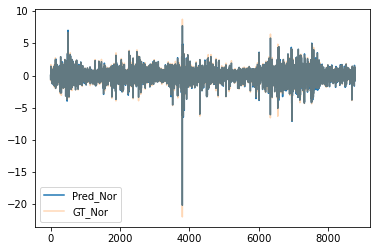

In [29]:
fig = plt.figure()
plt.plot(Return_Close_Pred_Train_Nor, alpha = 1, label = "Pred_Nor")
plt.plot(Return_Close_Label_Train_Nor, alpha = 0.3, label = "GT_Nor")
plt.legend()
plt.show()


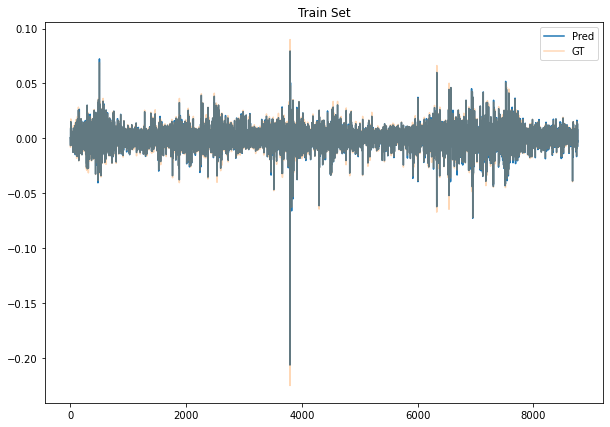

In [30]:
#P_Close_Pred_N = (P_Close - P_Close.mean(axis=0)) / P_Close.std(axis=0)

Return_Close_Pred_Train = Return_Std * Return_Close_Pred_Train_Nor + Return_Mean

fig = plt.figure(figsize=(10, 7))
plt.plot(Return_Close_Pred_Train, alpha = 1, label = "Pred")
plt.plot(Return_Close_Label_Train, alpha = 0.3, label = "GT")
plt.title("Train Set")
plt.legend()
plt.show()

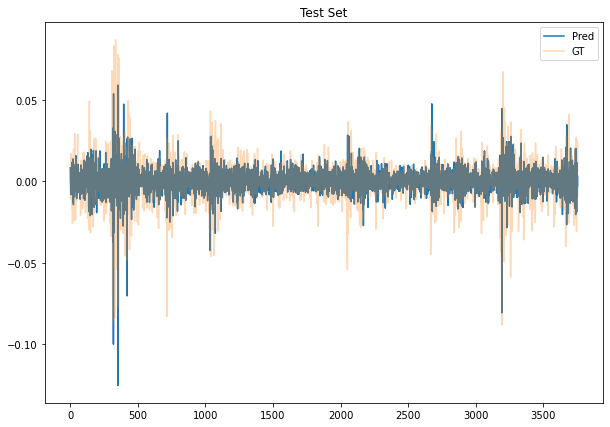

In [31]:
Return_Close_Pred_Test = Return_Std * Return_Close_Pred_Test_Nor + Return_Mean

fig = plt.figure(figsize=(10, 7))
plt.plot(Return_Close_Pred_Test, alpha = 1, label = "Pred")
plt.plot(Return_Close_Label_Test, alpha = 0.3, label = "GT")
plt.title("Test Set")
plt.legend()
#plt.savefig('./output/Test Set - 12-12-20 - 3.png')

plt.show()


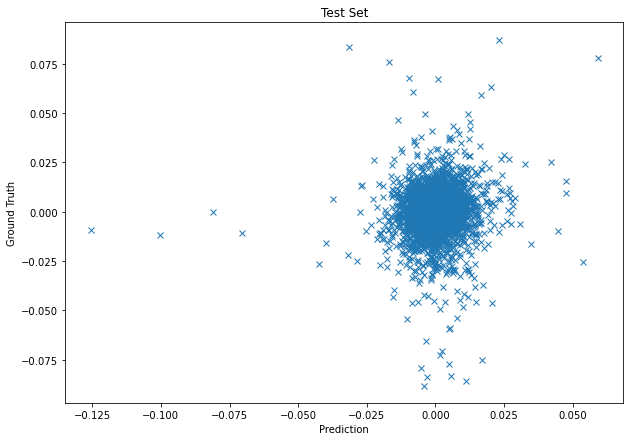

In [32]:
Return_Close_Pred_Test = Return_Std * Return_Close_Pred_Test_Nor + Return_Mean

fig = plt.figure(figsize=(10, 7))
plt.plot(Return_Close_Pred_Test, Return_Close_Label_Test, "x")
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title("Test Set")
#plt.legend()
#plt.savefig('./output/Test Set - GT vs Pred - SPINN 3.png')

plt.show()
